# ⌨️ Summary ⌨️

In this notebook we will go over a number of ensemble methods in which we look ensembling the output of regression probabilities:
1. Hill Climbing (OOF ensembling) 
1. Scipy Optimize (Nelder-Mead)
1. Logistic Regression Ensembling
1. Mean Ensembling 
1. Weighted Ensembling

We will be using a scoring method to measure the training prediction as a baseline in many of the above ensemble methods. This notebook uses **rmse** as the scoring method which we try to minimize 

# 📩 Import Libraries & Data  📩

In [1]:
import pandas as pd 
import numpy as np 
from sklearn.metrics import * 
import os 
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LassoLarsCV, LinearRegression

from scipy.optimize import minimize
from sklearn.metrics import log_loss, cohen_kappa_score
from sklearn.metrics import classification_report

In [2]:
from functools import partial
import numpy as np
import scipy as sp

In [3]:
OVERFIT_THRESHOLD = 0.4  # see section, anythin less than this score will be removed

folds = 5

TYPE = "Regression" #Regression
target = "Strength"

SCALING = True

In [4]:
df_train = pd.read_csv("/kaggle/input/playground-series-s3e9/train.csv", index_col = 0)
df_test = pd.read_csv("/kaggle/input/playground-series-s3e9/test.csv", index_col = 0)
sub = pd.read_csv("/kaggle/input/playground-series-s3e9/sample_submission.csv",index_col = 0)
df_train

df_train.drop_duplicates(inplace = True,ignore_index  = True)

y = df_train[target]
y = np.ravel(y)
len(y)

5407

In [5]:
PATH = '/kaggle/input/pss3e9-best-val-scores'
PATH = PATH+"/"
FILES = os.listdir(PATH)
print([file for file in FILES])

['v34_test_preds_LR.csv', 'v16_val_opt_multi.csv', 'v22_val_preds_cat.csv', 'v39_val_preds_GRAD.csv', 'v42_test_preds_rf.csv', 'v41_val_preds_ET.csv', 'v45_val_preds_nn.csv', 'v42_val_preds_rf.csv', 'v41_test_preds_ET.csv', 'v36_val_preds_SVR.csv', 'v10_test_preds_best.csv', 'v35_val_preds_Ridge.csv', 'v10_val_preds_best.csv', 'v39_test_preds_GRAD.csv', 'v40_val_preds_XGB.csv', 'v28_test_preds_LGB.csv', 'v28_val_preds_LGB.csv', 'v45_test_preds_nn.csv', 'v22_test_preds_cat.csv', 'v35_test_preds_Ridge.csv', 'v16_test_opt_multi.csv', 'V36_test_preds_SVR.csv', 'V40_test_preds_XGB.csv', 'v34_val_preds_LR.csv']


# 📋 Create Datasets 📋
* We have a set of train prediction files (csv) and test predictions 
* We will load these into a list and read them into a Dataframe

In [6]:
train_files = [file for file in FILES if "val" in file]
test_files = [file for file in FILES if "test" in file]
print("Length train:",len(train_files),"length test:", len(test_files))

Length train: 12 length test: 12


In [7]:
def sort_func(file):
    return int(file.split("_")[0][1:])

train_files.sort(key=sort_func)
test_files.sort(key=sort_func)
# train_files = train_files[:-1]
# test_files = test_files[:-1]
train_files

['v10_val_preds_best.csv',
 'v16_val_opt_multi.csv',
 'v22_val_preds_cat.csv',
 'v28_val_preds_LGB.csv',
 'v34_val_preds_LR.csv',
 'v35_val_preds_Ridge.csv',
 'v36_val_preds_SVR.csv',
 'v39_val_preds_GRAD.csv',
 'v40_val_preds_XGB.csv',
 'v41_val_preds_ET.csv',
 'v42_val_preds_rf.csv',
 'v45_val_preds_nn.csv']

In [8]:
train_preds_list = []
test_preds_list = []  

for i in range(len(train_files)): 

    train_preds_list.append(pd.read_csv(PATH+train_files[i], index_col =0 ).reset_index(drop = True))
    test_preds_list.append(pd.read_csv(PATH+test_files[i], index_col =0 ).reset_index(drop = True))

train_preds_list[0]

,Strength
0,22.182461
1,34.642754
2,37.086204
3,44.266044
4,45.212618
...,...
5402,28.530934
5403,40.977921
5404,34.814607
5405,50.206926


In [9]:
train_preds_concat = train_preds_list[0]
test_preds_concat = test_preds_list[0]

#### Create large dataframe

In [10]:
train_preds_concat = train_preds_list[0]
test_preds_concat = test_preds_list[0]

for i in range(1,len(train_preds_list)): 
    train_preds_concat = pd.merge(train_preds_concat,train_preds_list[i], left_index= True, right_index = True,how = "left",suffixes =(f'_x{i}', f'_y{i}'))
    test_preds_concat = pd.merge(test_preds_concat,test_preds_list[i], left_index= True, right_index = True,how = "left",suffixes=(f'_x{i}', f'_y{i}'))
test_preds_concat

,Strength,0_x2,0_y2,0_x4,0_y4,0_x6,0_y6,0_x8,0_y8,0_x10,0_y10,0
0,46.149525,47.478049,47.128842,47.175467,46.179587,45.599026,42.987472,47.893781,44.974808,48.849067,47.785325,47.543438
1,19.258347,21.892811,21.721599,20.919473,24.973551,25.225409,24.269632,21.831325,18.397978,20.672381,20.549035,20.934480
2,29.124040,31.703218,32.063198,30.763081,28.617513,28.553475,26.962157,31.375187,32.210743,33.437323,33.290618,30.304050
3,47.086895,47.094387,47.691050,46.319632,45.401917,45.099265,44.784434,47.504564,46.094560,47.732989,46.823947,47.502470
4,27.755177,31.981737,32.202188,30.158846,34.586591,35.068920,34.974360,29.845622,29.900600,33.695428,31.125145,33.026634
...,...,...,...,...,...,...,...,...,...,...,...,...
3600,31.076597,32.647872,32.594495,32.812447,32.691226,33.025095,33.993886,31.446817,31.467745,33.875617,32.482015,33.914543
3601,32.917250,34.548778,34.605877,34.498380,30.417587,30.227425,28.403186,33.054753,36.237680,35.113164,35.876657,33.515915
3602,38.949220,39.305259,39.101308,41.079302,37.172717,37.451428,36.444739,39.092701,35.073840,39.755646,37.916197,38.126880
3603,42.701140,33.414606,33.242047,31.450540,39.033444,38.726254,39.139110,33.001010,30.999390,33.483226,33.204654,34.702050


In [11]:
print("null values test:",test_preds_concat.isna().sum().sum())
print("null values train:",train_preds_concat.isna().sum().sum())

null values test: 0
null values train: 0


## Get Train scores
We will get the logloss of each train score

In [12]:
# Get scores 
train_scores = []
for col in train_preds_concat.columns:

    train_scores.append(mean_squared_error(y, train_preds_concat[col])**0.5)
print([i for i in train_scores] )

[11.92865435258124, 11.984928259699384, 11.989068942606304, 12.043844515795557, 12.699037570656037, 12.6938133067509, 12.557267963262532, 12.067205499754758, 12.148151862254423, 12.130137651158096, 12.078060668654478, 11.782938790222978]


# Weighted Ensemble (INT version) + rounder


In [13]:
preds = np.zeros(len(train_preds_concat))
tst_preds = np.zeros(len(test_preds_concat))

for i,col in enumerate(test_preds_concat.columns):
    preds += (train_preds_concat[col] * train_scores[i])
    tst_preds += (test_preds_concat[col] * train_scores[i])
    
Ensemble_TST = tst_preds/ sum(train_scores)
Ensemble_TRN = preds/ sum(train_scores)
Ensemble_TST

0       46.624613
1       21.759667
2       30.672800
3       46.574206
4       32.062584
          ...    
3600    32.674052
3601    33.243738
3602    38.271556
3603    35.295813
3604    23.359619
Name: Strength, Length: 3605, dtype: float64

In [14]:
score_weighted = mean_squared_error(y,Ensemble_TRN)**0.5
print("Ensemble Weighted:",score_weighted)

Ensemble Weighted: 11.988467632503292


In [15]:
sub_weighted = sub.copy(deep = True)
sub_weighted[target] =0
sub_weighted[target]=Ensemble_TST.values
sub_weighted.to_csv(f"weighted_{score_weighted:.4f}.csv")
sub_weighted

,Strength
id,
5407,46.624613
5408,21.759667
5409,30.672800
5410,46.574206
5411,32.062584
...,...
9007,32.674052
9008,33.243738
9009,38.271556


### Scipy optimize

In [16]:
from scipy import optimize
from functools import partial

class OptimizedEnsemble(object):
    def __init__(self):
        self.coef_ = 0    

    def _rmse_loss(self, coef, X, y):   
        ensemble = np.zeros(len(X))
        for i,col in enumerate(X.columns):
            ensemble = ensemble + coef[i] * X[col] 
        ll = mean_squared_error( y, ensemble )**0.5
        return ll

    def fit(self, X, y):
        loss_partial = partial(self._rmse_loss, X = X, y = y)
        initial_coef = [1/len(X.columns)]*len(X.columns)
        bounds = [(0,None)]* len(X.columns)
        constraints = ({'type': 'eq','fun': lambda w: 1-sum(w)}) #coefs must equal 1 i.e 1-sum(coefs) = 0
        self.coef_ = optimize.minimize(loss_partial, initial_coef,method= 'SLSQP', #'SLSQP','Nelder-Mead'
                                       bounds = bounds,constraints = constraints,
                                      options = {'ftol':1e-10})

    def predict(self, X, coef):
        ensemble = np.zeros(len(X))
        for i,col in enumerate(X.columns):
            ensemble = ensemble + coef[i] * X[col] 
        return ensemble

    def coefficients(self):
        return self.coef_['x']

In [17]:
opt = OptimizedEnsemble()
opt.fit(train_preds_concat,y)
coef = opt.coef_['x']
coef

array([1.52018398e-01, 0.00000000e+00, 0.00000000e+00, 5.98479599e-17,
       3.81639165e-17, 5.29090660e-17, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.46944695e-17, 0.00000000e+00, 8.47981602e-01])

In [18]:
opt_ensemble = opt.predict(train_preds_concat,opt.coef_['x'])
opt_score = mean_squared_error(y,opt_ensemble)**0.5
print(f"Mean RSME Opt: {opt_score:.4f}")

Mean RSME Opt: 11.7781


In [19]:
sub_opt = sub.copy(deep = True)
sub_opt[target] = opt.predict(test_preds_concat,opt.coef_['x']).values
sub_opt.to_csv(f"sub_opt_{opt_score:.4f}.csv")
sub_opt.head()

,Strength
id,
5407,47.331538
5408,20.679677
5409,30.124667
5410,47.439295
5411,32.225276


# Hard Voting 
* with regression this is just the best score

In [20]:
trn_hard = train_preds_concat.iloc[:,np.argmin(train_scores)]
tst_hard = test_preds_concat.iloc[:,np.argmin(train_scores)]
trn_hard

0       21.414999
1       33.437056
2       38.143276
3       43.124738
4       44.157565
          ...    
5402    23.831071
5403    42.096675
5404    33.922371
5405    46.004577
5406    49.290080
Name: 0, Length: 5407, dtype: float64

In [21]:
print("best file:'", train_files[np.argmin(train_scores)], "'\n")
score_hard = mean_squared_error(y,trn_hard)**0.5
print("Ensemble HardVoting:",score_hard)

best file:' v45_val_preds_nn.csv '

Ensemble HardVoting: 11.782938790222978


In [22]:
sub_hard_voting = sub.copy(deep = True)
sub_hard_voting[target] =0
sub_hard_voting[target]=tst_hard.values
sub_hard_voting.to_csv(f"hard_voting_{score_hard:.4f}.csv")
sub_hard_voting.head()

,Strength
id,
5407,47.543438
5408,20.934480
5409,30.304050
5410,47.502470
5411,33.026634


# Calibration


In [23]:
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.linear_model import RidgeCV, SGDClassifier,LogisticRegression, LogisticRegressionCV, SGDRegressor

models = {"LogisticRegression":LogisticRegression(n_jobs=5000),
         "SGDClassifier":SGDRegressor(loss="squared_error", penalty="l2"),
         "RidgeCV": RidgeCV(cv = 5,scoring = "neg_mean_squared_error")}

In [24]:
kfold = RepeatedKFold(n_splits= 5, n_repeats = 3)

In [25]:
if SCALING:
    print("Scaling")
    scaler = StandardScaler()
    X_temp = scaler.fit_transform(train_preds_concat)
    test_temp = scaler.transform(test_preds_concat)
else:
    X_temp = train_preds_concat.copy()
    test_temp = test_preds_concat.copy()

model = LinearRegression(n_jobs=1000) #SGDRegressor(loss="squared_error", penalty="l2") #RidgeCV(cv = 5,scoring = "neg_mean_squared_error")
model.fit(X_temp,y)
cal_trn_preds =  model.predict(X_temp)
cal_tst_preds = model.predict(test_temp)

score_cal = mean_squared_error(y,cal_trn_preds)**0.5
print("TRN score",score_cal)

Scaling
TRN score 11.741221090443275


In [26]:
sub_calibration = sub.copy(deep=True)
sub_calibration[target] =0
sub_calibration[target]=cal_tst_preds
sub_calibration.to_csv(f"sub_calibration_{score_cal:.4f}.csv")
sub_calibration.head()

,Strength
id,
5407,46.849008
5408,19.131350
5409,28.940583
5410,47.252107
5411,29.907947


# Mean Ensembling 

In [27]:
score_mean = mean_squared_error(y,train_preds_concat.mean(axis =1))**0.5
print("TRN score",score_mean)

TRN score 11.984511035962381


In [28]:
sub_mean = sub.copy(deep=True)
sub_mean[target] =0
sub_mean[target]=test_preds_concat.mean(axis =1).values
sub_mean.to_csv(f"sub_mean_{score_mean:.4f}.csv")
sub_mean.head()

,Strength
id,
5407,46.645366
5408,21.720502
5409,30.700384
5410,46.594676
5411,32.026771


# Viz

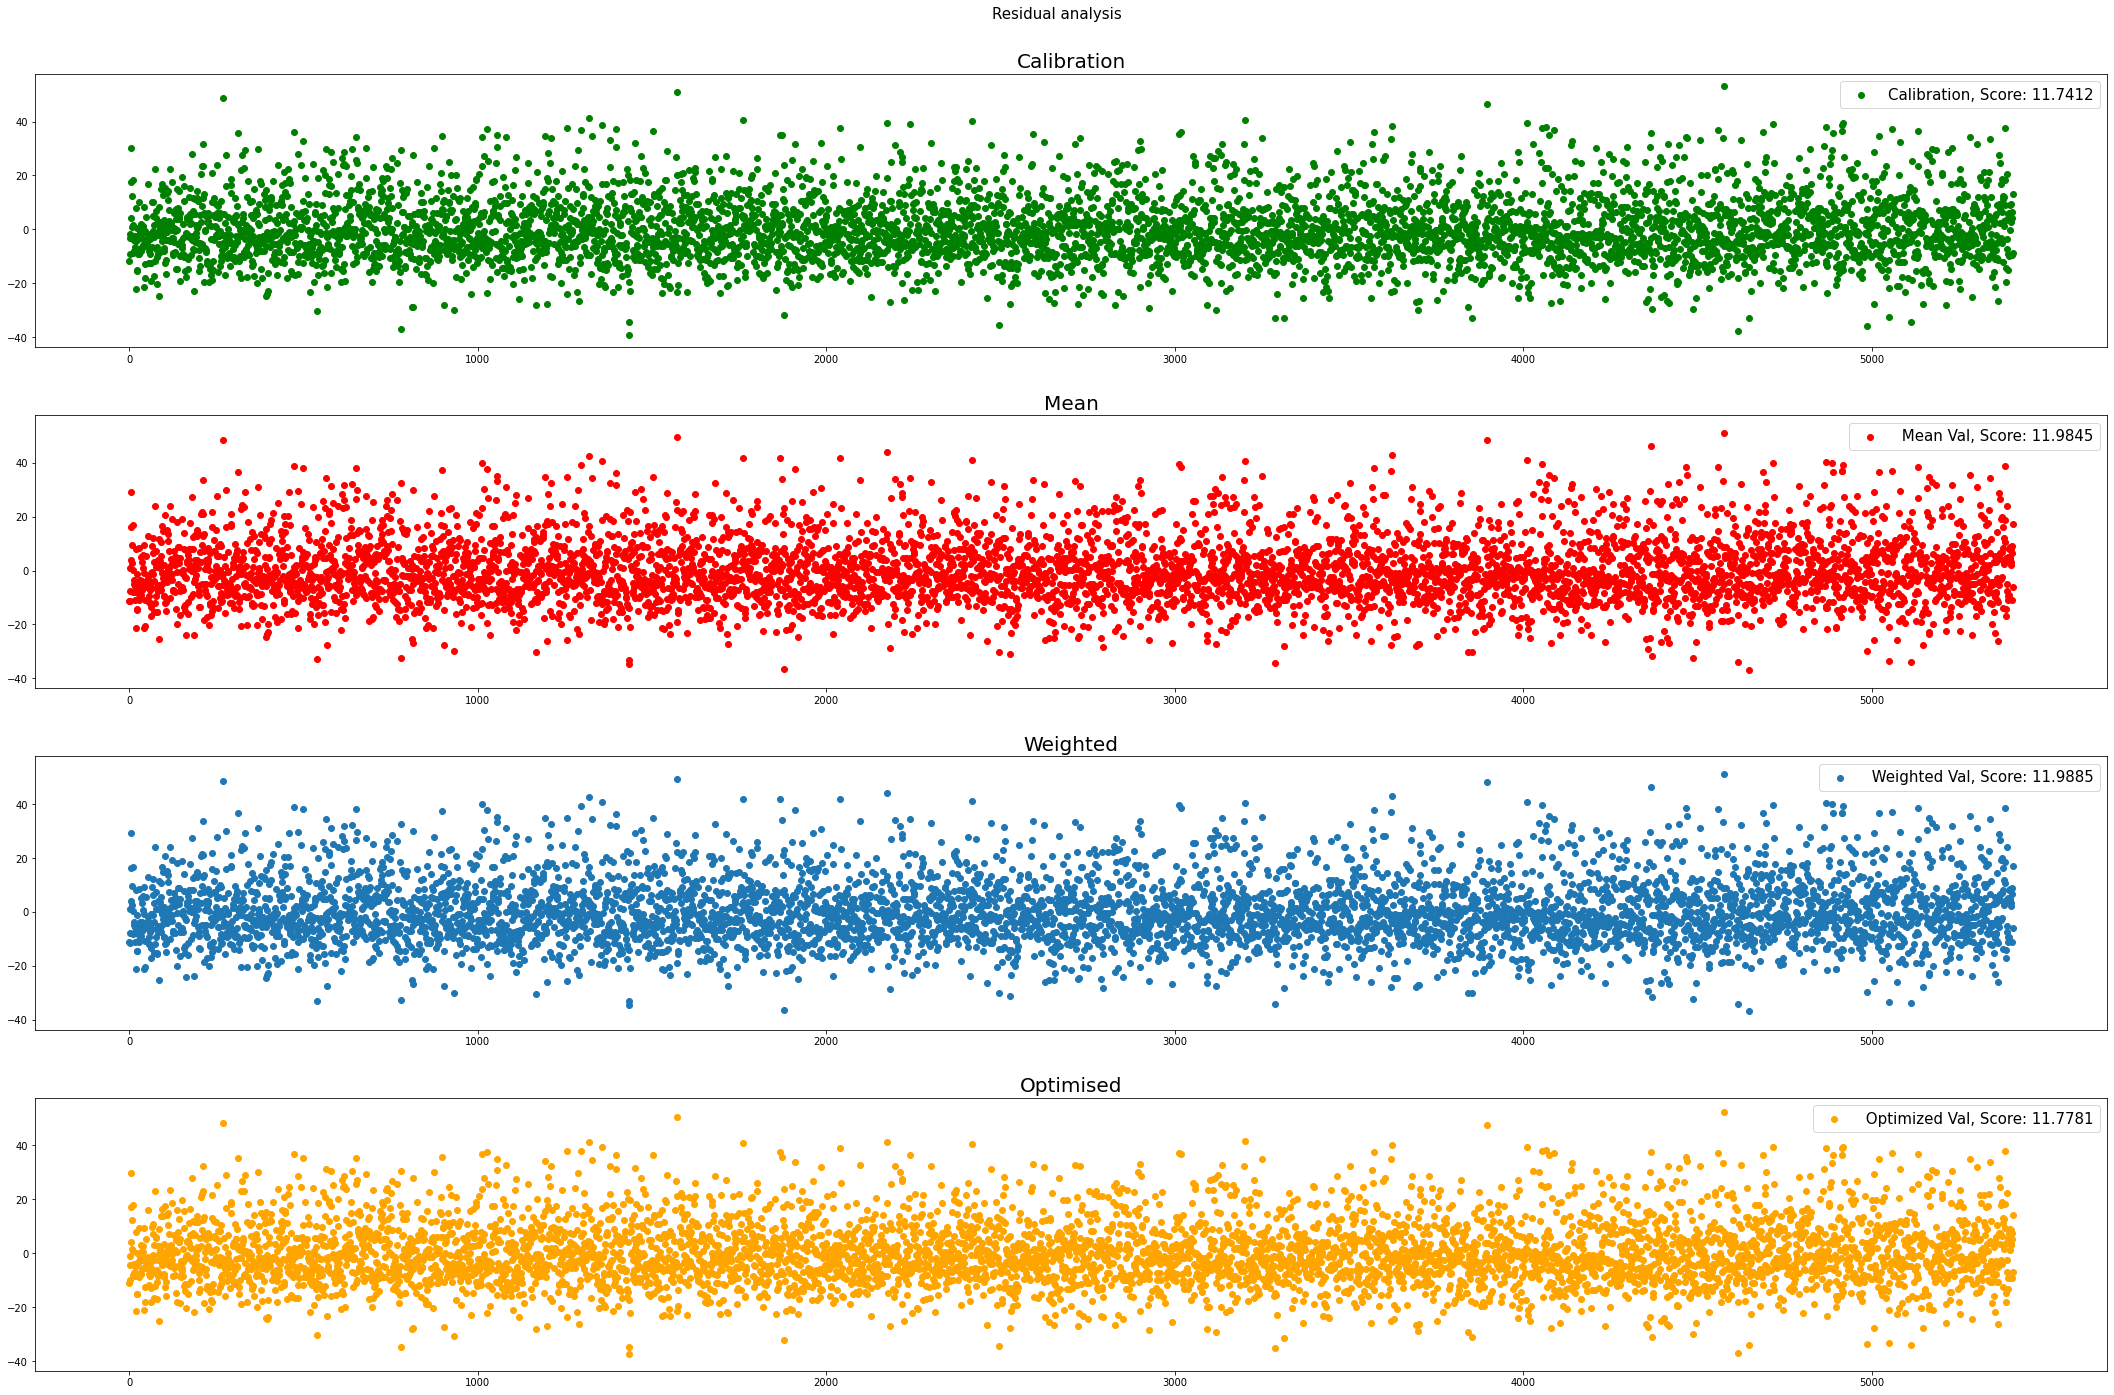

In [29]:
fig, ax = plt.subplots(4,1, figsize = (30,20),sharey = True)
ax = np.ravel(ax)

res_cal = y- cal_trn_preds
ax[0].scatter(x = [i for i in range(len(res_cal))], y = res_cal, label = f"Calibration, Score: {score_cal:.4f}", color = "g")
ax[0].set_title("Calibration", fontsize = 20)

res_mean = y- train_preds_concat.mean(axis =1)
ax[1].scatter(x = [i for i in range(len(res_mean))], y = res_mean, label = f" Mean Val, Score: {score_mean:.4f}", color = "r")
ax[1].set_title("Mean", fontsize = 20)

res_weighted = y -Ensemble_TRN
ax[2].scatter(x = [i for i in range(len(res_weighted))], y = res_weighted, label = f" Weighted Val, Score: {score_weighted:.4f}")
ax[2].set_title("Weighted", fontsize = 20)

res_opt = y -opt_ensemble.values
ax[3].scatter(x = [i for i in range(len(res_opt))], y = res_opt, label = f" Optimized Val, Score: {opt_score:.4f}", color = "orange")
ax[3].set_title("Optimised", fontsize = 20)


ax[0].legend(fontsize= 15)
ax[1].legend(fontsize= 15)
ax[2].legend(fontsize= 15)
ax[3].legend(fontsize= 15)

fig.suptitle("Residual analysis",fontsize= 15)
plt.tight_layout(pad= 3)
plt.show()

In [30]:
print(f"Calibration, Score: {score_cal:.4f}")
print(f"Mean Score: {score_mean:.4f}")
print(f"Weighted Score: {score_weighted:.4f}")
print(f"Optimized Score: {opt_score:.4f}")

Calibration, Score: 11.7412
Mean Score: 11.9845
Weighted Score: 11.9885
Optimized Score: 11.7781
